In [1]:
import mysql.connector
from api.db import DB_MOVIES
import topicsimilaritymodel_gravityai
import re
import json

In [2]:
# Define a way to cleanup the text, so we are comparing apples to apples.
strReplace = [('-', ' '),
             ('_', ' '),
             ('=', ' '),
             ('/', ' '),
             ('[(,),{,},<,>,»,«,’,\',‘,”,“,„,‚,\",&,#,*,§,€,$,+]', '')]

def stringReplace(myString):
    for pattern, repl in strReplace:
        myString = re.sub(pattern, repl, myString)
    return myString

In [3]:
cnx = mysql.connector.connect(
    user='gravityuser',
    password='D3m0D@atabase',
    host='mysql-topicsimilaritymodel-demo',
    database='wikipedia_movie_plots',
    port=3306
)

In [4]:
db = DB_MOVIES(cnx)

In [5]:
# Retrieve our "training" documents. These will be used to fit the model.
# The training documents shall look like the unknown documents we will be trying to match later.
# This means, if we are looking through News articles then we should train the model with News articles that
# have similar grammar and language. Likewise, if we are searching through publications then the training
# data should ideally consist of publications.
# Ideally, these training documents shall be examples of documents that we are looking for.
trainingDocsDB = db.get_documentsRandom(50)
trainingDocs = []
for doc in trainingDocsDB:
    if doc[1]:
        trainingDocs.append(stringReplace(doc[1]))
print(len(trainingDocs))

50


In [6]:
# Retrieve our "topic" text. This is what we will look for when matching.
# In this example, we are looking for a movie with a plot similar to "Back to the Future"
topicDB = db.get_topic(1)
topicText = stringReplace(topicDB[0][0])
print(topicText)

In 1985 Hill Valley California teenager Marty McFly and his girlfriend Jennifer Parker are chastised by the school principal for lateness. Marty auditions for the Battle of the Bands but is rejected for being too loud. At home Martys father George is bullied by his supervisor Biff Tannen while his mother Lorraine is an overweight depressed alcoholic. Lorraine recalls how she met George when her father hit him with his car.
Marty is invited by his friend eccentric inventor Dr. Emmett Brown to meet him in a parking lot in the early hours. Doc unveils a time machine built from a modified DeLorean and powered by plutonium stolen from terrorists. Preparing to demonstrate the time machine Doc sets the date to November 5 1955: the day he invented time travel. The terrorists arrive and shoot Doc. Marty escapes in the DeLorean but inadvertently activates the time machine.
Marty finds himself in 1955 without enough plutonium to return. He encounters the teenaged George who is bullied by his clas

In [7]:
# Retrieve our "unknown" documents. These are the documents we want to score.
docsDB = db.get_documents()
docs = []
docsWithAttributes = []
maxDocs = 0
for doc in docsDB:
    if doc[1]:
        docObj = {
            'id': doc[0],
            'text': stringReplace(doc[1])
        }
        docsWithAttributes.append(docObj)
print(len(docsWithAttributes))

34886


In [8]:
print(docsWithAttributes[:10])

[{'id': 'Kansas Saloon Smashers', 'text': 'A bartender is working at a saloon serving drinks to customers. After he fills a stereotypically Irish mans bucket with beer Carrie Nation and her followers burst inside. They assault the Irish man pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar smashing the fixtures mirrors and breaking the cash register. The bartender then sprays seltzer water in Nations face before a group of policemen appear and order everybody to leave.[1]'}, {'id': 'Love by the Light of the Moon', 'text': 'The moon painted with a smiling face hangs over a park at night. A young couple walking past a fence learn on a railing and look up. The moon smiles. They embrace and the moons smile gets bigger. They then sit down on a bench by a tree. The moons view is blocked causing him to frown. In the last scene the man fans the woman with his hat because the moon has left the sky and is perched over her shoulder to see

In [8]:
testData = [{
    "trainingDocs": trainingDocs,
    "topicText": [topicText],
    "documents": docsWithAttributes
}]

In [10]:
gravityai = topicsimilaritymodel_gravityai.Model('http://172.18.0.4:80')

In [11]:
response = gravityai.health()
print(response.text)

Health check is ok


In [13]:
response = gravityai.addJob(testData)
print(response.text)

{"data":{"id":"48e42a87-ae1b-4637-8ec6-8f2d818f9054","status":"Created","errorMessage":null},"isError":false,"errorMessage":null}


In [14]:
response = gravityai.getStatus("48e42a87-ae1b-4637-8ec6-8f2d818f9054")
print(response.text)

{"data":{"id":"48e42a87-ae1b-4637-8ec6-8f2d818f9054","status":"Complete","errorMessage":null},"isError":false,"errorMessage":null}


In [15]:
results = json.loads(gravityai.getResult("48e42a87-ae1b-4637-8ec6-8f2d818f9054").text)


In [16]:
import pandas as pd

In [17]:
# We can import our docs with attributes into a Pandas Dataframe.
resultsDF = pd.DataFrame(results["documents"])

In [18]:
# Lets print out the Dataframe. Now we have a 'score' attribute, that can be used for analysis.
resultsDF.sort_values(by='similarityScore', ascending=False)

,id,text,similarityScore
10322,Back to the Future,In 1985 Hill Valley California teenager Marty ...,1.000000
12066,Rookie of the Year,Henry Rowengartner Nicholas 12 year old Little...,0.999988
15181,Daddy Day Camp,Four years after the events of Daddy Day Care ...,0.999963
33155,Tokyo: The Last Megalopolis,The live action film is an adaptation of the f...,0.999949
33965,The Third Murder,Tomoaki Shigemori is a lawyer tasked with defe...,0.999945
...,...,...,...
3386,Northwest Rangers,A mountie tracks down a former childhood friend.,0.269321
7606,Heaven and Earth Magic,Smith explains:,0.258707
19263,Cloak Without Dagger,A fashion reporter is united with a former boy...,0.257614
4343,Tangier,In Tangier disgraced American war corresponden...,0.122719


In [19]:
# Let's take a look at the scores, graphically.
import matplotlib.pyplot as plt

In [20]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

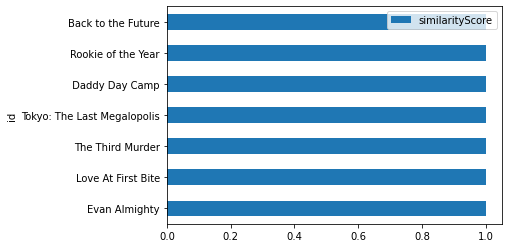

In [21]:
# Here is a bar graph of the scores.
resultsDF[resultsDF.similarityScore > .9999].sort_values(by='similarityScore', ascending=True).plot.barh(x='id', y='similarityScore')

In [22]:
# As we train topics we can begin to ascertain which scores indicate relevant results.
# We can call this the "cutoff score" and create an application that only shows users
# docs that have a score higher than that cutoff score.
# Here, lets see all values higher than .9999
# This returns a smaller subset of docs for the user to review.
resultsDF[resultsDF.similarityScore > .9999].sort_values(by='similarityScore', ascending=False)

,id,text,similarityScore
10322,Back to the Future,In 1985 Hill Valley California teenager Marty ...,1.000000
12066,Rookie of the Year,Henry Rowengartner Nicholas 12 year old Little...,0.999988
15181,Daddy Day Camp,Four years after the events of Daddy Day Care ...,0.999963
33155,Tokyo: The Last Megalopolis,The live action film is an adaptation of the f...,0.999949
33965,The Third Murder,Tomoaki Shigemori is a lawyer tasked with defe...,0.999945
9620,Love At First Bite,The infamous vampire Count Dracula is expelled...,0.999945
15197,Evan Almighty,Newly elected to Congress former local televis...,0.999915


In [23]:
response = gravityai.deleteJob("48e42a87-ae1b-4637-8ec6-8f2d818f9054")
print(response.text)

{"data":{"id":"48e42a87-ae1b-4637-8ec6-8f2d818f9054","status":"Deleted","errorMessage":null},"isError":false,"errorMessage":null}
